# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-preparation-and-cleaning" data-toc-modified-id="Data-preparation-and-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation and cleaning</a></div><div class="lev1 toc-item"><a href="#Comparison-pre-and-post-normalization" data-toc-modified-id="Comparison-pre-and-post-normalization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparison pre and post normalization</a></div><div class="lev1 toc-item"><a href="#PCA-analysis" data-toc-modified-id="PCA-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA analysis</a></div>

In [10]:
library(ggbiplot)
library(tidyverse, quiet=T)

library(caret, quiet=T)

In [2]:
dat0 <- read.csv("../datasets/Ultrasound/training_ultrasound.csv")
count = dplyr::count
n = dplyr::n

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )

head(dat.raw)
cat("Total number of unique entries per column:\n")
dat.raw %>% summarise_each(funs(n_distinct(.)))

cat("Distribution of measurements by subject")
dat.raw %>% count(SUBJID) %>% mutate(tot=n) %>% count(tot) %>% t

dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1)

STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,⋯,FLAZ,BHC_Z,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40,LOG10.FWT.GM,WTKG.estimate,Study
1,1002,2,Female,276,3540,50.3,NA,Category 2.0,1,⋯,2.142646,NA,0.8916001,0.8604704,3.614882,50.61003,NA,3.486183,3.063250,Study 1
1,1002,2,Female,276,3540,50.3,NA,Category 2.0,1,⋯,NA,NA,0.8916001,0.8604704,3.614882,50.61003,NA,NA,3.540000,Study 1
1,1002,2,Female,276,3540,50.3,NA,Category 2.0,1,⋯,NA,NA,0.8916001,0.8604704,3.614882,50.61003,NA,NA,10.740000,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.616571,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.712499,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.495569,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.712499,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.106900,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.419602,2.627857,Study 1


Total number of unique entries per column:


STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,⋯,FLAZ,BHC_Z,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40,LOG10.FWT.GM,WTKG.estimate,Study
2,2525,2,2,61,229,92,40,7,8,⋯,1656,193,717,1973,1932,710,185,6777,7217,2


Distribution of measurements by subject

tot,1,3,4,5,6,7,8,9,10,11,12,13,14,15
nn,34,220,449,469,231,97,116,220,250,292,84,46,11,6


# Data preparation and cleaning
We use the preProcess function from caret to prepare the data.

Procedure:

- remove all samples with only one measurement
- These attributes seem to be related to size: 
    - ABCIRCM (Abdominal Circumference)
    - HCIRCM (Head Circumference)
    - BPDCM (Biparietal diameter)
    - FEMURCM (Femur Length)
- the preProcess function will:
    - center and scale the data to make it normally distributed. 
    - do a PCA, to get a sense of whether these variables could be reduced to fewer dimensions
        - ideally we would like to reduce it to one variable, for the trajectory clustering
    - do imputation using knn
    
    

In [3]:
# clean data, remove samples with only one observation
dat.covars = dat %>% ungroup %>%
    select(ABCIRCM, HCIRCM, BPDCM, FEMURCM)

dat.preproc = dat.covars  %>%
    mutate_each(funs(as.numeric(.))) %>%
    preProcess(., method=c("center", "scale", "knnImpute", "pca"))

dat.preproc.nopca = dat.covars  %>%
    mutate_each(funs(as.numeric(.))) %>%
    preProcess(., method=c("center", "scale", "knnImpute" ))
#    preProcess(., method=c("center", "scale", "knnImpute", "YeoJohnson", "pca"))

dat.preproc$data %>% head


ABCIRCM,HCIRCM,BPDCM,FEMURCM
1.0812496,0.01748041,0.9542082,1.1299432
0.1618004,-0.42286538,0.4878348,0.5261815
0.1618004,-0.42286538,0.4878348,0.5261815
0.7747665,-0.23414576,0.9542082,1.0695670
0.7747665,-0.23414576,0.9542082,1.0695670
-0.7576487,-1.18822830,-0.7040084,-0.8020942


In [4]:
dat.preproc$mean

ABCIRCM    HCIRCM     BPDCM   FEMURCM 
24.385770 33.233273  7.258584  5.428495

In [5]:
dat.preproc$rotation

,PC1,PC2
ABCIRCM,-0.4988103,-0.7221488
HCIRCM,-0.5010410,0.3786742
BPDCM,-0.5001775,0.5425691
FEMURCM,-0.4999687,-0.2018064


Let's see how the predictor can impute the values from the originary frame:

In [6]:
dat.predicted = predict(
        dat.preproc %>% as.matrix,
        dat.covars 
        )

dat.predicted %>% head
dat.covars %>% head

ABCIRCM,HCIRCM,BPDCM,FEMURCM
32.5,33.4,9.1,7.3
NA,NA,NA,NA
NA,46.9,NA,NA
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2


ABCIRCM,HCIRCM,BPDCM,FEMURCM
32.5,33.4,9.1,7.3
NA,NA,NA,NA
NA,46.9,NA,NA
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2


In [7]:
dat.preproc$rotation


,PC1,PC2
ABCIRCM,-0.4988103,-0.7221488
HCIRCM,-0.5010410,0.3786742
BPDCM,-0.5001775,0.5425691
FEMURCM,-0.4999687,-0.2018064


# Comparison pre and post normalization


Warning message:
: Removed 30494 rows containing non-finite values (stat_density).

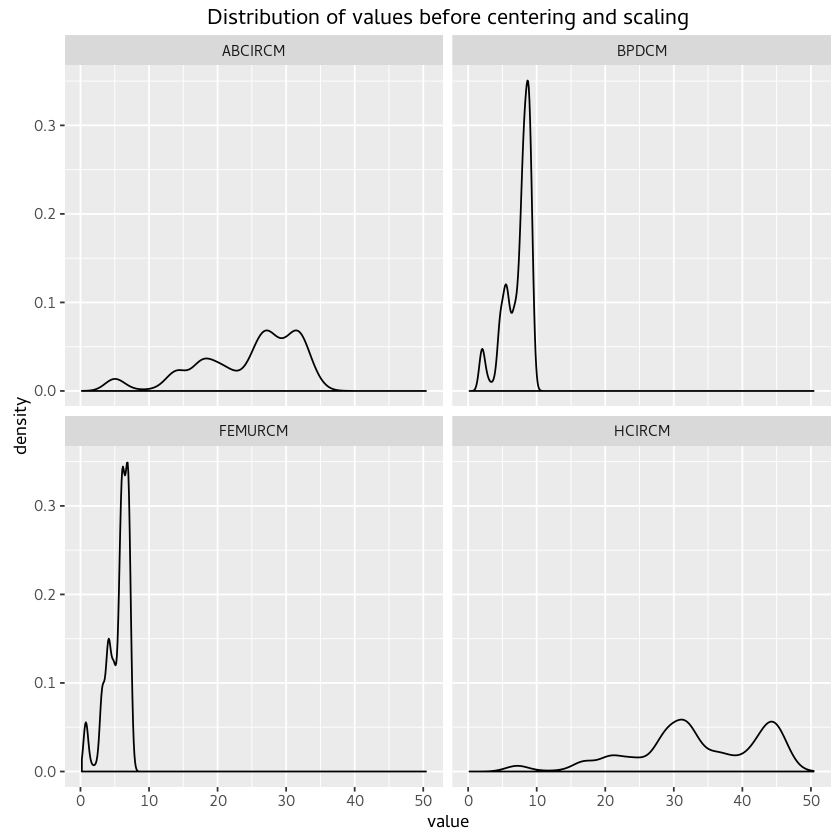

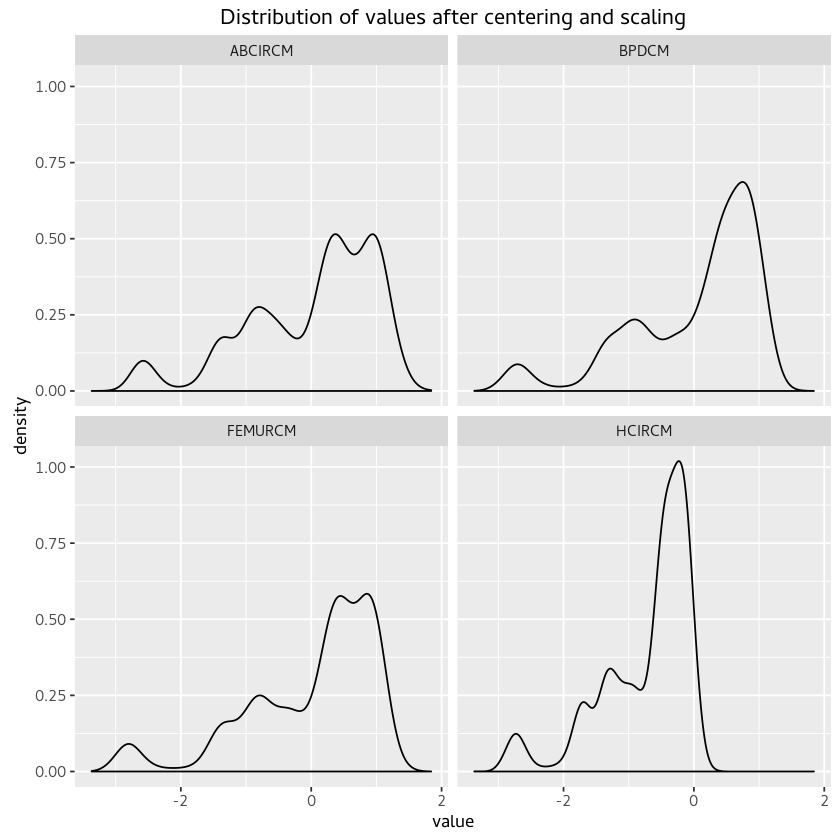

In [8]:

dat.covars %>%  gather(feature, value) %>% 
    ggplot(aes(x=value)) +
        facet_wrap(~feature) +
        geom_density() +
        ggtitle("Distribution of values before centering and scaling")


dat.preproc$data %>% gather(feature, value) %>% mutate(label="post-normalization") %>%
    ggplot(aes(x=value)) +
        facet_wrap(~feature) +
        geom_density() +
        ggtitle("Distribution of values after centering and scaling")



# PCA analysis

I still haven't discovered how to get a biplot from the output of preProcess, so I'll recalculate the PCA manually.

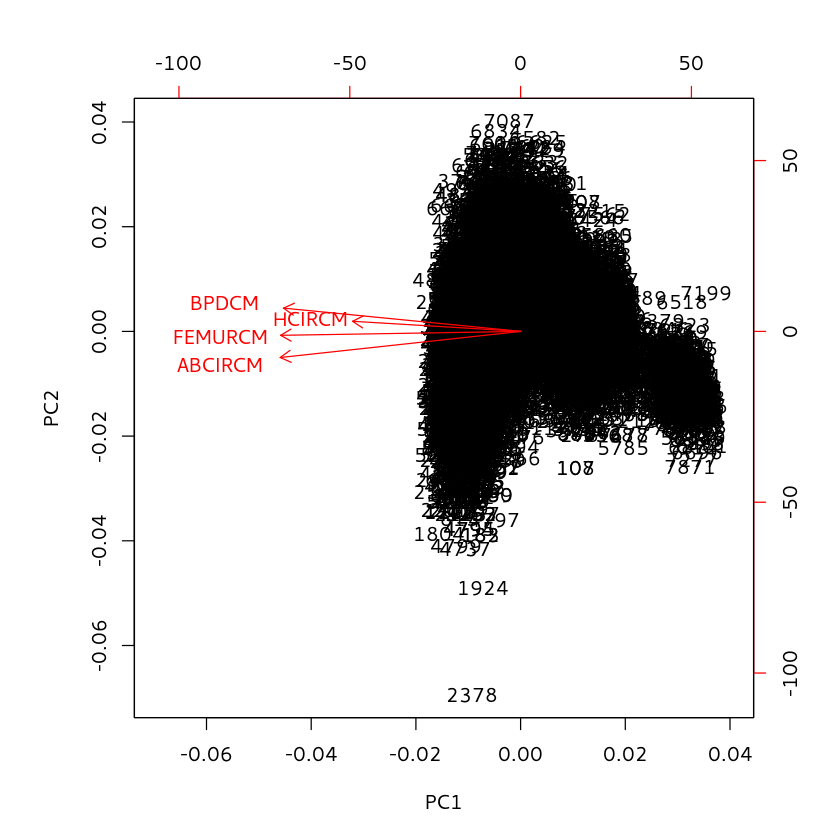

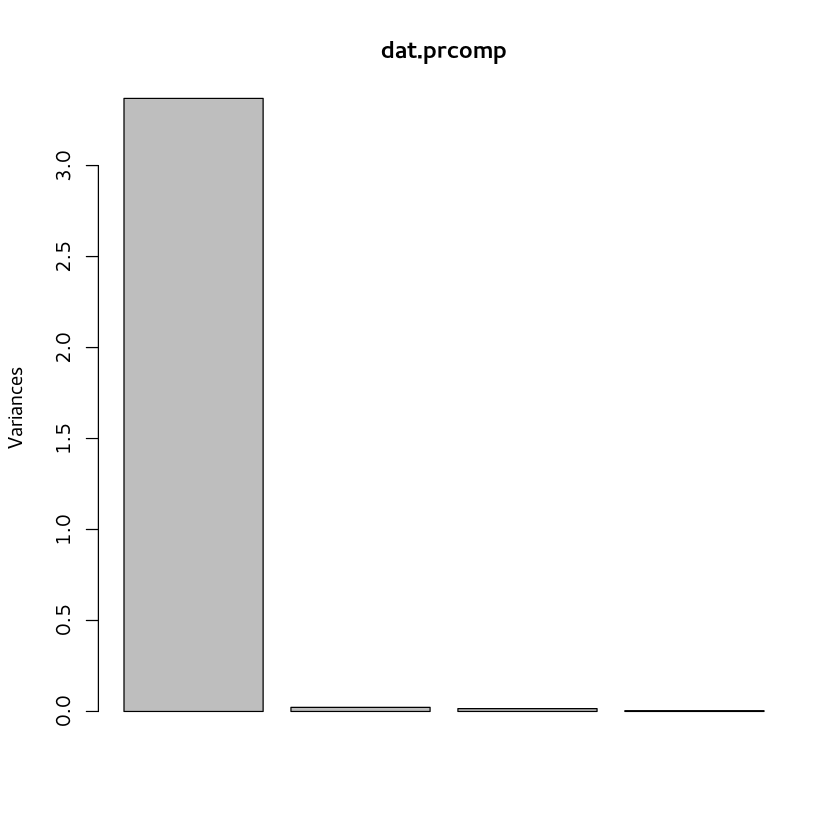

In [9]:
dat.prcomp = dat.preproc$data %>% prcomp
biplot(dat.prcomp)
plot(dat.prcomp)

In [1]:

9 * 40

[1] 360